https://machinelearningmastery.com/lstm-autoencoders/

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb

https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

1. MinMax scalar
2. Different loss functions
3. How to take output of encoder part

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [3]:
!pip install -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 71kB 10.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=7ed8543cefb46119309e0e98db54a4cbb9429b5de88306b885ec5543dd43c565
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=0c94db765e917442d4c615fcdb1e6c9f3b91b1e741e96b934de1b72dca0e6186
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [4]:
plt.rcParams["figure.figsize"] = [16,9]

In [6]:
# _initializing constant variables
#input_file_path = os.getcwd() + f'/../data/output_csv/processed_data.csv'
input_file_path = f'/content/drive/MyDrive/Colab Notebooks/processed_data.csv'
col_names = ['timestamp (s)','subject_id', 'activityID', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']
main_df = pd.read_csv(input_file_path,names=col_names)

In [7]:
main_df

,timestamp (s),subject_id,activityID,X1,Y1,Z1,X2,Y2,Z2
0,37.66,101,1,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145
1,37.67,101,1,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538
2,37.68,101,1,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831
3,37.69,101,1,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374
4,37.70,101,1,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582
...,...,...,...,...,...,...,...,...,...
1564137,3409.07,108,7,-1.68428,-8.97338,3.43203,-0.231392,-0.391747,0.180935
1564138,3409.08,108,7,-1.72527,-9.04964,3.35469,-0.252115,-0.338597,0.180709
1564139,3409.09,108,7,-1.53312,-8.97455,3.43429,-0.176675,-0.311570,0.172539
1564140,3409.10,108,7,-1.50362,-9.01479,3.20395,-0.173602,-0.291495,0.170721


In [8]:
main_df[['subject_id', 'activityID']].groupby(['subject_id']).agg(['count'])

,activityID
,count
subject_id,
101,184121
102,206437
103,148188
104,198283
105,211739
106,202082
107,198600
108,214692


In [9]:
main_df = main_df.loc[main_df['subject_id'] != 103]

In [10]:
main_df.sort_values(by=['activityID'], inplace=True)
main_df[['timestamp (s)', 'activityID']].groupby(['activityID']).agg(['count'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,timestamp (s)
,count
activityID,
1,170454
2,156264
3,169253
4,203884
6,164530
7,186114
16,154959
17,210496


In [11]:
drop_cols = ['timestamp (s)', 'subject_id']
main_df.drop(columns=drop_cols, axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
main_df

,activityID,X1,Y1,Z1,X2,Y2,Z2
0,1,2.21530,8.279150,5.58753,-0.004750,0.037579,-0.011145
551485,1,4.83383,0.394111,8.65537,-0.014979,-0.013408,-0.003733
551486,1,4.90084,0.504997,8.38659,-0.016116,-0.037889,-0.011223
551487,1,5.01421,0.693482,8.34916,-0.027256,0.010782,-0.028180
551488,1,4.90352,0.505668,8.46360,-0.028567,-0.001170,-0.036104
...,...,...,...,...,...,...,...
835265,17,-4.65970,7.386130,5.75697,2.426860,-0.878047,-0.376608
835266,17,-4.31906,7.459380,5.76183,2.523730,-0.979366,-0.292547
835267,17,-4.44687,7.683860,5.29731,2.610760,-0.987398,-0.275793
835255,17,-3.81678,5.034520,6.58577,1.011110,-0.474947,-0.529987


In [14]:
activities = set(list(main_df.activityID.unique()))
final_sensor_data = pd.DataFrame(columns=main_df.columns)
timesteps = 50
features = 6

for activity in activities:
    activity_df = main_df.loc[main_df['activityID'] == activity]

    extra_rows = len(activity_df.index)%timesteps
    timestep_rows = (len(activity_df.index) - extra_rows)

    if extra_rows > 0:
      activity_df = activity_df.iloc[:timestep_rows]

    final_sensor_data = pd.concat([final_sensor_data, activity_df])

In [15]:
activity_data = final_sensor_data.iloc[:, 0].values
sensor_data = final_sensor_data.iloc[:, 1:].values.astype('float32')
print(sensor_data.shape)

(1415800, 6)


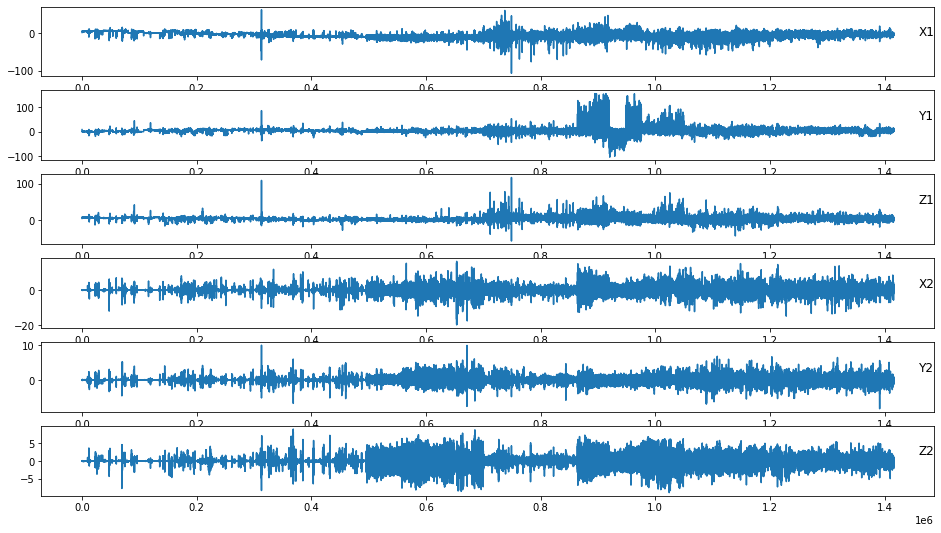

In [16]:
plt.figure()
for col in range(features):
	plt.subplot(features, 1, col+1)
	plt.plot(sensor_data[:, col])
	plt.title(col_names[col+3], y=0.5, loc='right')

plt.show()

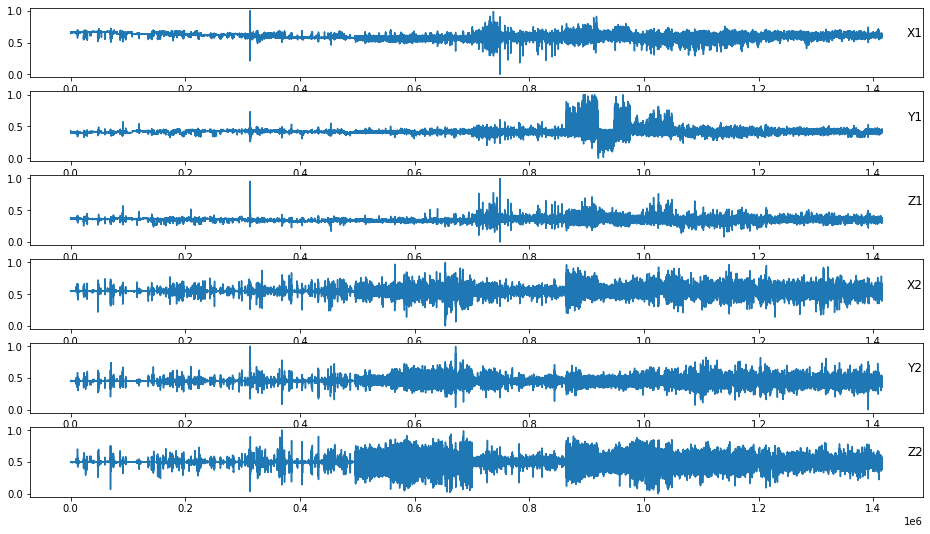

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for idx in range(features):
    sensor_data[:, idx] = MinMaxScaler().fit_transform(sensor_data[:, idx].reshape(-1, 1)).reshape(1,-1)

plt.figure()
for col in range(features):
	plt.subplot(features, 1, col+1)
	plt.plot(sensor_data[:, col])
	plt.title(col_names[col+3], y=0.5, loc='right')

plt.show()

In [18]:
sensor_data.shape

(1415800, 6)

In [19]:
activity_data.shape

(1415800,)

In [20]:
# _input data format - [samples, timesteps, features]
sensor_data = sensor_data.reshape(-1, timesteps, features)
sensor_data.shape

(28316, 50, 6)

In [21]:
# _input data format - [samples, timesteps, features]
activity_data = activity_data.reshape(-1, timesteps)
activity_data.shape

(28316, 50)

In [22]:
def build_model(hp):

    lstm_layer_1_output_params = hp.Int(
        'output_1', min_value=60, max_value=100, step=5)
    lstm_layer_2_output_params = hp.Int(
        'output_2', min_value=30, max_value=60, step=5)
    
    lstm_layer_1_dropoutrate_params = hp.Float(
        'dropoutrate_1', min_value=0.2, max_value=0.5, step=0.1)
    lstm_layer_2_dropoutrate_params = hp.Float(
        'dropoutrate_2', min_value=0.2, max_value=0.5, step=0.1)

    activation_fn_params = hp.Choice(
        'act_fn', values=['relu', 'tanh'])

    learning_rate_params = hp.Choice(
        'learning_rate', values=[1e-2, 1e-3])

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(lstm_layer_1_output_params, activation=activation_fn_params, input_shape=(timesteps, features), return_sequences=True),
        tf.keras.layers.LSTM(lstm_layer_2_output_params, activation=activation_fn_params, return_sequences=False),
        tf.keras.layers.Dropout(rate=lstm_layer_1_dropoutrate_params),

        tf.keras.layers.RepeatVector(timesteps),

        tf.keras.layers.LSTM(lstm_layer_2_output_params, activation=activation_fn_params, return_sequences=True),
        tf.keras.layers.LSTM(lstm_layer_1_output_params, activation=activation_fn_params, return_sequences=True),
        tf.keras.layers.Dropout(rate=lstm_layer_2_dropoutrate_params),

        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(features))    
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_params),loss='mae')

    return model

In [23]:
tuner_bo = kt.tuners.BayesianOptimization(
                build_model,objective=kt.Objective('val_loss', direction="min"), max_trials =30, executions_per_trial=2
)

tuner_bo.search(sensor_data, sensor_data, epochs=5, batch_size=64 ,validation_split=0.3)
best_model = tuner_bo.get_best_models(num_models=1)[0]
print(best_model.summary())

best_hp = tuner_bo.get_best_hyperparameters()[0]
print(best_hp.values)

Trial 30 Complete [00h 01m 01s]
val_loss: 0.025184335187077522

Best val_loss So Far: 0.023602266795933247
Total elapsed time: 04h 22m 26s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 95)            38760     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                37440     
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 50, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 60)            29040     
_________________________________________________________________
lstm_3 (LST

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=5, 
    restore_best_weights=True,
)

history = best_model.fit(sensor_data, sensor_data, epochs=50, validation_split=0.4, callbacks=[early_stopping], batch_size=32)

Epoch 1/50
531/531 [==============================] - 184s 340ms/step - loss: 0.0156 - val_loss: 0.0253
Epoch 2/50
531/531 [==============================] - 177s 333ms/step - loss: 0.0154 - val_loss: 0.0250
Epoch 3/50
531/531 [==============================] - 175s 329ms/step - loss: 0.0151 - val_loss: 0.0250
Epoch 4/50
531/531 [==============================] - 179s 338ms/step - loss: 0.0151 - val_loss: 0.0245
Epoch 5/50
531/531 [==============================] - 182s 343ms/step - loss: 0.0149 - val_loss: 0.0245
Epoch 6/50
531/531 [==============================] - 173s 327ms/step - loss: 0.0144 - val_loss: 0.0242
Epoch 7/50
531/531 [==============================] - 176s 332ms/step - loss: 0.0142 - val_loss: 0.0232
Epoch 8/50
531/531 [==============================] - 179s 337ms/step - loss: 0.0139 - val_loss: 0.0225
Epoch 9/50
531/531 [==============================] - 174s 328ms/step - loss: 0.0137 - val_loss: 0.0222
Epoch 10/50
531/531 [==============================] - 174s 328m

In [25]:
# lstm_ae_model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(50, activation='relu', input_shape=(timesteps, features), return_sequences=True),
#     tf.keras.layers.LSTM(25, activation='relu', return_sequences=False),
#     tf.keras.layers.Dropout(rate=0.2),

#     tf.keras.layers.RepeatVector(timesteps),

#     tf.keras.layers.LSTM(25, activation='relu', return_sequences=True),
#     tf.keras.layers.LSTM(50, activation='relu', return_sequences=True),
#     tf.keras.layers.Dropout(rate=0.2),

#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(features))    
# ])
# lstm_ae_model.compile(optimizer='adam', loss='mae')
# lstm_ae_model.summary()

In [26]:
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     min_delta=0.001, 
#     patience=5, 
#     restore_best_weights=True,
# )

# history = lstm_ae_model.fit(sensor_data, sensor_data, epochs=50, validation_split=0.4, callbacks=[early_stopping], batch_size=32)

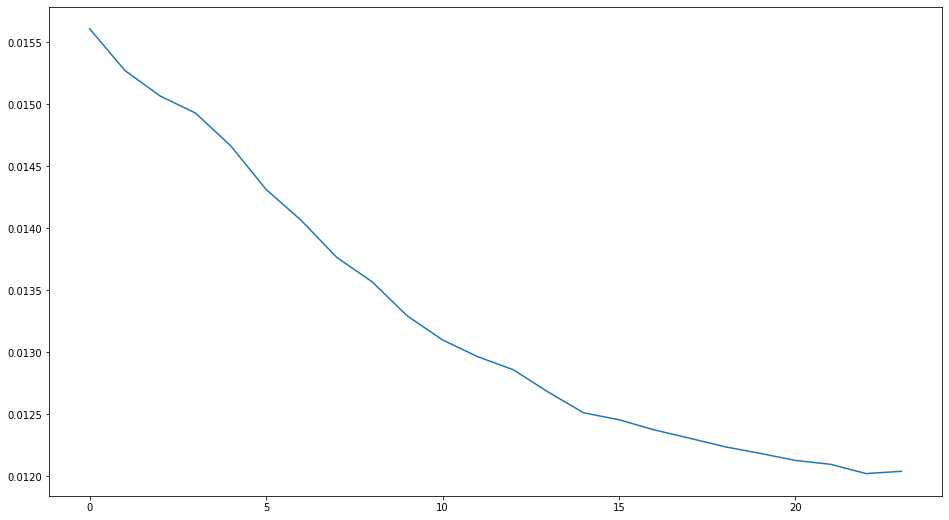

In [27]:
plt.plot(history.history['loss'])
plt.show()

In [28]:
get_3rd_layer_output = tf.keras.backend.function([best_model.layers[0].input],
                                  [best_model.layers[2].output])
encoder_output = get_3rd_layer_output(sensor_data)
sensor_features = np.asarray(encoder_output).astype('float32')
sensor_features = sensor_features.reshape(sensor_features.shape[1], sensor_features.shape[2])
sensor_features.shape

(28316, 60)

In [29]:
activity_data.shape

(28316, 50)

In [30]:
activity_data = activity_data[:, 0]
activity_data = activity_data.reshape(-1, 1).astype('int32')
activity_data.shape

(28316, 1)

In [31]:
final_data = np.append(activity_data, sensor_features, axis=1)
final_data.shape

(28316, 61)

In [32]:
np.savetxt("sensor_features_lstm_tuned.csv", final_data, delimiter=",")